In [1]:
import numpy as np
import pandas as pd
from hyperopt import hp
from fedot_ind.core.architecture.pipelines.abstract_pipeline import AbstractPipeline, ApiTemplate
from pathlib import Path
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot.core.repository.tasks import TsForecastingParams, Task, TaskTypesEnum
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from fedot_ind.api.utils.path_lib import PROJECT_PATH
from fedot_ind.core.architecture.settings.computational import backend_methods as np

In [2]:
def plot_mean_sample(X,y, labels:list = [], n_channel: int = 1):
    mean_sample = []
    if len(labels) == 0:
        labels = list(np.unique(y))
    for label in labels:
        mean_sample.append(np.mean(X[y == label] , axis=0)) # Данные класса 1
    #ax = plt.gca()
    channels = [f'Channel {x}' for x in range(n_channel)]
    df = pd.DataFrame(mean_sample).T
    df.columns = labels
    df.plot(kind ='line',subplots=True, layout=(1,len(labels)),figsize=(20,10))
    plt.legend(fontsize='small')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [3]:
def plot_mean_sample_multi(X,y, labels:list = [], n_channel: int = None):
    mean_sample = {}
    if len(labels) == 0:
        labels = list(np.unique(y))
    if n_channel is None:
        n_channel = X.shape[1]
    channels = [f'Channel {x}' for x in range(n_channel)]
    for label in labels:
        mask = y == label
        for chn in range(n_channel):
            mean_sample.update({f'Label_{label}_channel_{chn}':np.mean(X[mask.flatten(),chn,:] , axis=0)}) # Данные класса 1
    #ax = plt.gca()
    df = pd.DataFrame(mean_sample)
    df.plot(kind ='line')
    plt.suptitle('Усреднённые семплы по классам')
    plt.legend(fontsize='small')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [4]:
finetune = False
metric_names = ('f1', 'accuracy', 'precision', 'roc_auc')
api_config = dict(problem='classification',
                  metric='accuracy',
                  timeout=1,
                  pop_size=10,
                  with_tunig=False,
                  n_jobs=2,
                  logging_level=20)
pipeline_creator = AbstractPipeline(task='classification')

## Классификация с помощью геометрических преобразований

In [5]:
ECG = 'ECG200'
topological_model = ['topological_extractor', 'rf']
recurrence_model = ['recurrence_extractor', 'quantile_extractor', 'rf']

In [6]:
ecg_dataset = pipeline_creator.create_input_data(ECG)

### Topo Hyperparams

In [7]:
topological_params ={'window_size': {'hyperopt-dist': hp.choice, 'sampling-scope': [[x for x in range(5, 50, 5)]]},
         'stride': {'hyperopt-dist': hp.choice, 'sampling-scope': [[x for x in range(1, 10, 1)]]}},

In [8]:
stat_params = {'window_size': {'hyperopt-dist': hp.choice, 'sampling-scope': [[x for x in range(5, 50, 5)]]},
         'stride': {'hyperopt-dist': hp.choice, 'sampling-scope': [[x for x in range(1, 10, 1)]]},
         'add_global_features': {'hyperopt-dist': hp.choice, 'sampling-scope': [[True, False]]}}

In [9]:
recurrence_params =         {'window_size': {'hyperopt-dist': hp.choice, 'sampling-scope': [[x for x in range(5, 50, 5)]]},
         'stride': {'hyperopt-dist': hp.choice, 'sampling-scope': [[x for x in range(1, 10, 1)]]},
         'rec_metric': (hp.choice, [['cosine', 'euclidean']]),
         'image_mode': {'hyperopt-dist': hp.choice, 'sampling-scope': [[True, False]]}},

In [10]:
rec_metric = 'cosine'
image_mode = True
window_size = 10
stride = 1

In [11]:
topological_node_dict = {'topological_extractor':{'window_size':window_size,
                                         'stride':stride}}

In [12]:
recurrence_node_dict = {'recurrence_extractor':{'window_size':window_size,
                                         'stride':stride,
                                          'rec_metric':rec_metric,
                                           'image_mode':image_mode}}

In [13]:
feature_extractor = pipeline_creator.create_pipeline(topological_node_dict)
feature_matrix = feature_extractor.fit(ecg_dataset[0])

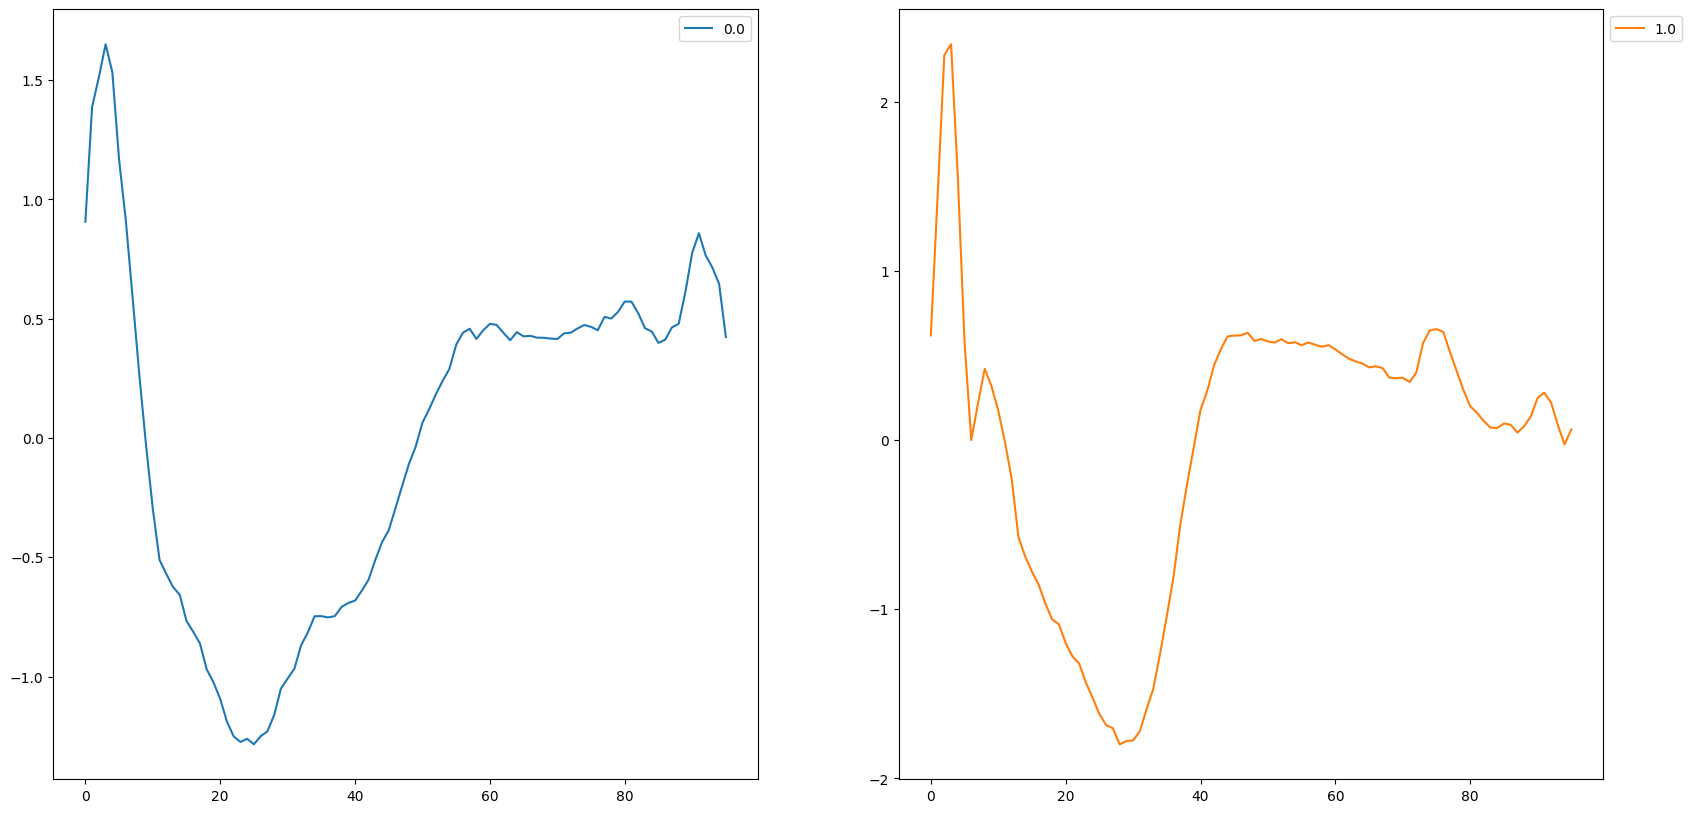

In [14]:
plot_mean_sample(ecg_dataset[0].features,ecg_dataset[0].target)

In [15]:
feature_extractor = pipeline_creator.create_pipeline(recurrence_node_dict)
feature_matrix = feature_extractor.fit(ecg_dataset[0])

In [16]:
feature_matrix.predict.shape

(100, 3, 87, 87)

In [17]:
explain_config = {'method': 'recurrence',
                  'samples': 1,
                  'metric': 'mean'}

In [18]:
from fedot_ind.tools.explain.explain import RecurrenceExplainer

rec_explain = RecurrenceExplainer(model=feature_extractor,
                                  features=feature_matrix.predict,
                                  target=ecg_dataset[0].target)

In [19]:
rec_explain.explain(**explain_config)

In [20]:
rec_explain.visual()

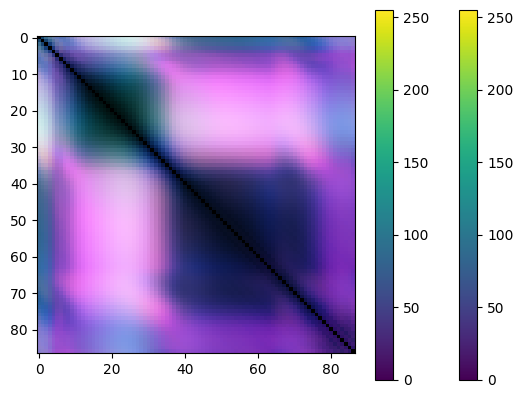

In [23]:
from fedot_ind.core.operation.transformation.data.kernel_matrix import colorise
metric= 'mean'
name = 'test'
for classes, rec_matrix in rec_explain.rec_matrix_by_cls.items():
        aggregated_rec_matrix = rec_explain.aggregate_func[metric](rec_matrix, axis=0)
        aggregated_rec_matrix = colorise(aggregated_rec_matrix)
        plt.imshow(aggregated_rec_matrix.T)
        plt.colorbar()

In [24]:
topological_list_model =  {'topological_extractor':{'window_size':window_size,
                                         'stride':stride},
                       'logit':{}}

In [25]:
result_dict_stat = ApiTemplate(api_config=api_config,
                          metric_list=metric_names).eval(dataset=ECG,
                                                         finetune=finetune,
                                                         initial_assumption = topological_list_model)

Creating Dask Server
2024-11-04 12:17:22,942 - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-11-04 12:17:22,978 - State start
2024-11-04 12:17:22,988 -   Scheduler at: inproc://10.64.4.172/5996/1
2024-11-04 12:17:22,989 -   dashboard at:  http://10.64.4.172:8787/status
2024-11-04 12:17:22,990 - Registering Worker plugin shuffle
2024-11-04 12:17:23,009 -       Start worker at: inproc://10.64.4.172/5996/4
2024-11-04 12:17:23,010 -          Listening to:          inproc10.64.4.172
2024-11-04 12:17:23,011 -           Worker name:                          0
2024-11-04 12:17:23,012 -          dashboard at:          10.64.4.172:61698
2024-11-04 12:17:23,012 - Waiting to connect to: inproc://10.64.4.172/5996/1
2024-11-04 12:17:23,013 - -------------------------------------------------
2024-11-04 12:17:23,014 -               Threads:                          8
2024-11-04 12:17:23,014 -                Memory:      

[I 2024-11-04 12:17:32,502] A new study created in memory with name: no-name-3fe59ef6-c84c-4c3b-88a4-1ddc5fdd9233


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-11-04 12:17:45,116] Trial 0 finished with value: -0.7694592988710637 and parameters: {'0 || logit | C': 1.915826061214538, '0 || logit | penalty': 'l1', '0 || logit | solver': 'liblinear'}. Best is trial 0 with value: -0.7694592988710637.
[I 2024-11-04 12:17:46,121] Trial 1 finished with value: -0.7795603089720737 and parameters: {'0 || logit | C': 3.228270381361707, '0 || logit | penalty': 'l1', '0 || logit | solver': 'liblinear'}. Best is trial 1 with value: -0.7795603089720737.
[I 2024-11-04 12:17:57,947] Trial 2 finished with value: -0.7896613190730838 and parameters: {'0 || logit | C': 6.264562801880035, '0 || logit | penalty': 'l1', '0 || logit | solver': 'liblinear'}. Best is trial 2 with value: -0.7896613190730838.
[I 2024-11-04 12:17:59,146] Trial 3 finished with value: -0.7896613190730838 and parameters: {'0 || logit | C': 3.8629989120165695, '0 || logit | penalty': 'l2', '0 || logit | solver': 'liblinear'}. Best is trial 2 with value: -0.7896613190730838.
[I 2024-11-

In [26]:
result_dict_stat['metrics']

,accuracy,f1,precision
0,0.56,0.0,0.249


In [11]:
ecg_dataset[0].features.shape

(100, 1, 96)

In [12]:
multimodal_pipeline = {'recurrence_extractor': {
        'window_size': 30,
        'stride': 5,
        'image_mode': True},
        'resnet_model': {
            'epochs': 50,
            'batch_size': 8,
            'model_name': 'ResNet50'}}

In [13]:
result_dict = ApiTemplate(api_config=api_config,
                          metric_list=('f1', 'accuracy')).eval(dataset=ECG,
                                                               finetune=finetune,
                                                               initial_assumption=multimodal_pipeline)

Creating Dask Server
2024-11-04 12:44:17,000 - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-11-04 12:44:17,032 - State start
2024-11-04 12:44:17,048 -   Scheduler at: inproc://10.64.4.172/21776/1
2024-11-04 12:44:17,049 -   dashboard at:  http://10.64.4.172:8787/status
2024-11-04 12:44:17,050 - Registering Worker plugin shuffle
2024-11-04 12:44:17,061 -       Start worker at: inproc://10.64.4.172/21776/4
2024-11-04 12:44:17,062 -          Listening to:          inproc10.64.4.172
2024-11-04 12:44:17,063 -           Worker name:                          0
2024-11-04 12:44:17,063 -          dashboard at:          10.64.4.172:63240
2024-11-04 12:44:17,064 - Waiting to connect to: inproc://10.64.4.172/21776/1
2024-11-04 12:44:17,064 - -------------------------------------------------
2024-11-04 12:44:17,065 -               Threads:                          8
2024-11-04 12:44:17,066 -                Memory:   

100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch: 1, Accuracy= 0.45454545454545453, Training Loss: 0.80


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch: 2, Accuracy= 0.6545454545454545, Training Loss: 0.64


100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch: 3, Accuracy= 0.7090909090909091, Training Loss: 0.69
EarlyStopping counter: 1 out of 15


100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


Epoch: 4, Accuracy= 0.7090909090909091, Training Loss: 0.60


100%|██████████| 7/7 [00:01<00:00,  3.72it/s]


Epoch: 5, Accuracy= 0.7272727272727273, Training Loss: 0.60
EarlyStopping counter: 1 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


Epoch: 6, Accuracy= 0.6363636363636364, Training Loss: 0.64
EarlyStopping counter: 2 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.64it/s]


Epoch: 7, Accuracy= 0.7636363636363637, Training Loss: 0.52


100%|██████████| 7/7 [00:01<00:00,  3.57it/s]


Epoch: 8, Accuracy= 0.6909090909090909, Training Loss: 0.67
EarlyStopping counter: 1 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.78it/s]


Epoch: 9, Accuracy= 0.7272727272727273, Training Loss: 0.54
EarlyStopping counter: 2 out of 15


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch: 10, Accuracy= 0.7818181818181819, Training Loss: 0.47


100%|██████████| 7/7 [00:01<00:00,  3.64it/s]


Epoch: 11, Accuracy= 0.7090909090909091, Training Loss: 0.58
EarlyStopping counter: 1 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.69it/s]


Epoch: 12, Accuracy= 0.7454545454545455, Training Loss: 0.50
EarlyStopping counter: 2 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


Epoch: 13, Accuracy= 0.7636363636363637, Training Loss: 0.52
EarlyStopping counter: 3 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.70it/s]


Epoch: 14, Accuracy= 0.8, Training Loss: 0.47


100%|██████████| 7/7 [00:01<00:00,  3.56it/s]


Epoch: 15, Accuracy= 0.6727272727272727, Training Loss: 0.58
EarlyStopping counter: 1 out of 15


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


Epoch: 16, Accuracy= 0.7090909090909091, Training Loss: 0.58
EarlyStopping counter: 2 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.73it/s]


Epoch: 17, Accuracy= 0.8, Training Loss: 0.49
EarlyStopping counter: 3 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


Epoch: 18, Accuracy= 0.7636363636363637, Training Loss: 0.45


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 19, Accuracy= 0.8363636363636363, Training Loss: 0.44


100%|██████████| 7/7 [00:03<00:00,  2.15it/s]


Epoch: 20, Accuracy= 0.8545454545454545, Training Loss: 0.37


100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Epoch: 21, Accuracy= 0.6545454545454545, Training Loss: 0.71
EarlyStopping counter: 1 out of 15


100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


Epoch: 22, Accuracy= 0.7272727272727273, Training Loss: 0.49
EarlyStopping counter: 2 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


Epoch: 23, Accuracy= 0.7818181818181819, Training Loss: 0.51
EarlyStopping counter: 3 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.61it/s]


Epoch: 24, Accuracy= 0.7272727272727273, Training Loss: 0.58
EarlyStopping counter: 4 out of 15


100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


Epoch: 25, Accuracy= 0.7090909090909091, Training Loss: 0.72
EarlyStopping counter: 5 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.55it/s]


Epoch: 26, Accuracy= 0.7454545454545455, Training Loss: 0.52
EarlyStopping counter: 6 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.67it/s]


Epoch: 27, Accuracy= 0.7090909090909091, Training Loss: 0.63
EarlyStopping counter: 7 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.69it/s]


Epoch: 28, Accuracy= 0.7090909090909091, Training Loss: 0.50
EarlyStopping counter: 8 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.60it/s]


Epoch: 29, Accuracy= 0.7090909090909091, Training Loss: 0.66
EarlyStopping counter: 9 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.64it/s]


Epoch: 30, Accuracy= 0.6545454545454545, Training Loss: 0.76
EarlyStopping counter: 10 out of 15


100%|██████████| 7/7 [00:02<00:00,  3.36it/s]


Epoch: 31, Accuracy= 0.7272727272727273, Training Loss: 0.64
EarlyStopping counter: 11 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.64it/s]


Epoch: 32, Accuracy= 0.6727272727272727, Training Loss: 0.72
EarlyStopping counter: 12 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.62it/s]


Epoch: 33, Accuracy= 0.6727272727272727, Training Loss: 0.70
EarlyStopping counter: 13 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.56it/s]


Epoch: 34, Accuracy= 0.6727272727272727, Training Loss: 0.87
EarlyStopping counter: 14 out of 15


100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


Epoch: 35, Accuracy= 0.8181818181818182, Training Loss: 0.48
EarlyStopping counter: 15 out of 15
Early stopping
AssumptionsHandler - Initial pipeline was fitted successfully
AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 2.3 MiB, max: 196.5 MiB
ApiComposer - Initial pipeline was fitted in 257.7 sec.
AssumptionsHandler - Preset was changed to fast_train due to fit time estimation for initial model.
ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 1 min. Set of candidate models: ['xgboost', 'catboost', 'logit', 'dt', 'rf', 'mlp', 'lgbm', 'one_class_svm', 'inception_model', 'nbeats_model', 'tcn_model', 'deepar_model', 'channel_filtration', 'eigen_basis', 'wavelet_basis', 'fourier_basis', 'quantile_extractor', 'topological_extractor', 'minirocket_extractor', 'scaling', 'normalization', 'simple_imputation', 'kernel_pca'].
ApiComposer - Timeout is too small for composing and is skipped because fit_time is 257.743017 s

In [15]:
result_dict['metrics']

,accuracy,f1
0,0.63,0.0


### Прогнозирование с помощью топологических признаков

In [16]:
horizon = 365
PATH = Path(PROJECT_PATH, 'examples', 'data', 'ices_areas_ts.csv')
time_series_df = pd.read_csv(PATH).iloc[:, 1:]
target_series = time_series_df['Карское'].values
input_data = InputData.from_numpy_time_series(target_series,task=Task(TaskTypesEnum.ts_forecasting,task_params=TsForecastingParams(forecast_length=horizon)))
train_data, test_data = train_test_data_setup(input_data)

### Построение бейзлайна и топологической модели

In [17]:
from fedot_ind.core.repository.initializer_industrial_models import IndustrialModels
repo = IndustrialModels().setup_repository()

In [28]:
pipeline_based = PipelineBuilder().add_node('lagged').add_node('treg').build()
pipeline_based.fit(train_data)

LaggedTransformationImplementation - Window size of lagged transformation was changed by WindowSizeSelector from 0 to 1095


KeyboardInterrupt: 

In [ ]:
topological_pipeline = PipelineBuilder().add_node('lagged').add_node('topological_extractor').add_node('lagged', branch_idx=2).join_branches('treg').build()
topological_pipeline.fit(train_data)

In [ ]:
### Прогноз

In [ ]:
forecast_base = np.ravel(pipeline_based.predict(test_data).predict)
forecast_topo = np.ravel(topological_pipeline.predict(test_data).predict)

forecast_base[forecast_base < 0] = 0
forecast_topo[forecast_topo < 0] = 0

### Визуализация прогнозов

In [ ]:
plt.plot(input_data.features, label='real data')
plt.plot(np.arange(len(target_series) - horizon, len(target_series)),
         forecast_base, label='forecast base')
plt.plot(np.arange(len(target_series) - horizon, len(target_series)),
         forecast_topo, label='forecast topo')

plt.grid()
plt.legend()
plt.show()

In [ ]:
print('base')
print(mean_squared_error(test_data.target, forecast_base, squared=False))
print(
    mean_absolute_percentage_error(
        test_data.target +
        1000,
        forecast_base +
        1000))

In [ ]:
print('topo')
print(mean_squared_error(test_data.target, forecast_topo, squared=False))
print(
    mean_absolute_percentage_error(
        test_data.target +
        1000,
        forecast_topo +
        1000))